In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from training import set_loader, set_model, parse_option
from retrieval import KNNClassifier
from demo import UofTData, plot_classes_preds, plot_imgs

In [2]:
config = parse_option("--data_folder datasets --color_augmentation None --random False".split())
config.dataset = "GLRv2"
train_loader, val_loader, test_loader = set_loader(config)

config.dataset = "GLRv2_5_preprocessed_file_names"
train_loader_names, val_loader_names, test_loader_names = set_loader(config)

train_loader.dataset.transform = test_loader.dataset.transform

config.network = "efficientnet-b0"
efficientnet, _ = set_model(config, train_loader)
efficientnet.load_state_dict(torch.load("models/best_no_freeze_efficientnet-b0.pth")["model_state_dict"])
config.network = "senet-50"
se_resnet, _ = set_model(config, train_loader)
se_resnet.load_state_dict(torch.load("models/best_freeze_senet-50.pth")["model_state_dict"])
config.network = "swin"
swin, _ = set_model(config, train_loader)
swin.load_state_dict(torch.load("models/swin_best_lr0.001_nofreeze_bs32.pth")["model_state_dict"])

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [3]:
knn_model = KNNClassifier([efficientnet, se_resnet, swin], k=5)

In [4]:
knn_model.create_embeddings(train_loader, train_loader_names)
knn_model.save_embeddings("big_embeddings")

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torchvision\datasets\folder.py", line 232, in __getitem__
    sample = self.loader(path)
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torchvision\datasets\folder.py", line 269, in default_loader
    return pil_loader(path)
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\torchvision\datasets\folder.py", line 250, in pil_loader
    img = Image.open(f)
  File "c:\Users\ryanr\Desktop\APS360-Landmarkers\ENV\lib\site-packages\PIL\Image.py", line 3030, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='datasets\\landmark-recognition-1k\\190822\\afdafa6dead45385.jpg'>


In [4]:
# load in the training set embeddings
knn_model.load_embeddings(
    ["embeddings\model_0_embeddings.npy",
    "embeddings\model_1_embeddings.npy",
    "embeddings\model_2_embeddings.npy",], 
    ["embeddings\model_0_labels.npy",
    "embeddings\model_1_labels.npy",
    "embeddings\model_2_labels.npy",],
    ["embeddings\model_0_fns.npy",
    "embeddings\model_1_fns.npy",
    "embeddings\model_2_fns.npy",])


this is correct
Image to predict:


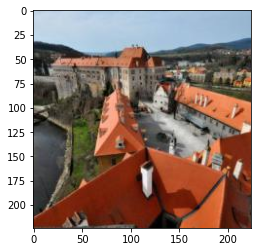

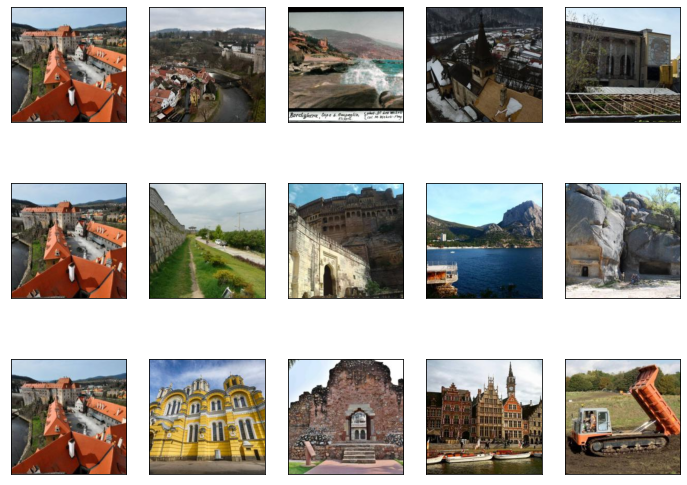

In [5]:
idx = 3622
(sample1, label1), (fn1, _) = val_loader.dataset[idx], val_loader_names.dataset[idx]
idx = 4831
(sample2, label2), (fn2, _) = val_loader.dataset[idx], val_loader_names.dataset[idx]
preds, top_classes_images, top_preds = knn_model.predict(torch.concat([sample1.unsqueeze(0), sample2.unsqueeze(0)]))

top_classes_images = np.stack(top_classes_images, axis=0).transpose(1, 0, 2)

fn = (fn1, fn2)
labels = (label1, label2)

if preds[0] == labels[0]:
    print("this is correct")
else:
    print("this is wrong") 
print("Image to predict:")
images_list = np.concatenate(top_classes_images[0], axis=0).flatten()
img = mpimg.imread(fn[0])
plt.imshow(img)
out = plot_imgs(images_list, m=3, k=5)

this is wrong
Image to predict:


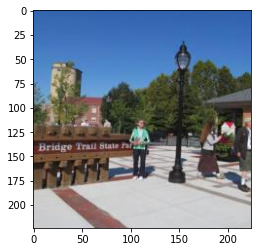

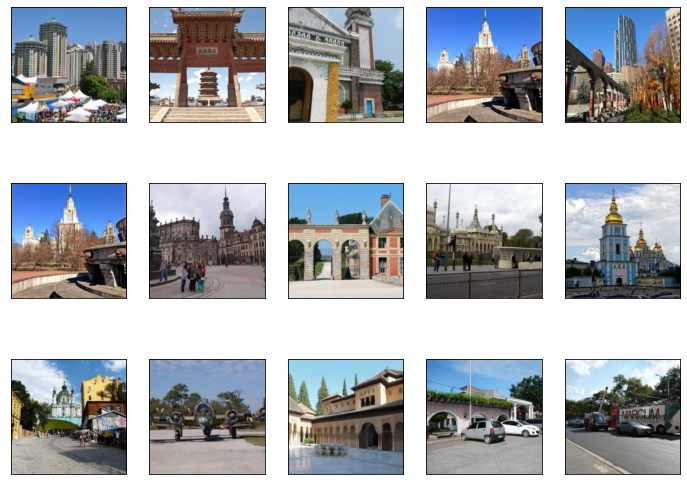

In [6]:
if preds[1] == labels[1]:
    print("this is correct")
else:
    print("this is wrong") 
print("Image to predict:")
images_list = np.concatenate(top_classes_images[1], axis=0).flatten()
img = mpimg.imread(fn[1])
plt.imshow(img)
out = plot_imgs(images_list, m=3, k=5)

In [7]:
dataset = UofTData("datasets", train=True)
dataset.transform = train_loader.dataset.transform
uoft_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)
uoft_loader_names = torch.utils.data.DataLoader(
            dataset=dataset.imgs, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)

In [8]:
knn_model.add_embeddings(uoft_loader, uoft_loader_names)

this is correct
Image to predict:


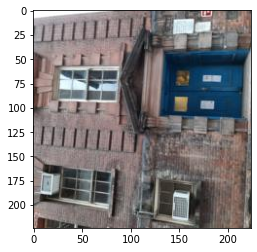

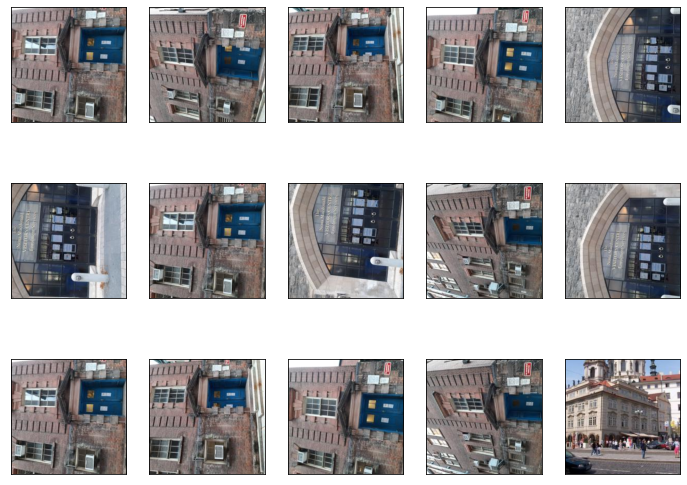

In [9]:
test_dataset = UofTData("datasets", train=False)
test_dataset.transform = train_loader.dataset.transform
test_uoft_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)
acc_total = 0
num_samples = 0
idx = 0
(sample, label), (fn, _) = test_dataset[idx], test_dataset.imgs[idx]
pred, top_classes_images, top_preds = knn_model.predict(sample.unsqueeze(0))

if pred == label:
    print("this is correct")
else:
    print("this is wrong") 
print("Image to predict:")
images_list = np.concatenate(top_classes_images, axis=0).flatten()
img = mpimg.imread(fn)
plt.imshow(img)
plt.show()
out = plot_imgs(images_list, m=3, k=5)



In [10]:
test_dataset = UofTData("datasets", train=False)
test_dataset.transform = train_loader.dataset.transform
test_uoft_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)
acc_total = 0
num_samples = 0

for idx, (images, labels) in enumerate(test_uoft_loader):
    preds, images, top_preds= knn_model.predict(images)
    num_samples += preds.shape[0]
    acc_total += np.sum(preds == labels.detach().numpy())
print(f"Accuracy for the UofT data is {acc_total/num_samples}")



Accuracy for the UofT data is 1.0
